# Data Wrangling And Analysing Twitter Archive of WeRateDogs


Importing libraries

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

## Gathering Data

The data for this project will be gathered from three sources:
1. Downloadable csv file in Udacity resources. This file has been filtered for tweets with ratings only from WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets.

2. TSV file containing image predictions of dogs for each tweet which is hosted on Udacity's server (https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv). This file will be downloaded programatically using requests library

3. JSON data on each tweet that will be queried from Twitter's API using the Tweepy library. From this additinal information on tweets like retweet count and favorite ("like") count will be gathered

**Reading the twitter archive data**

In [2]:
#Read the Twitter Archive Data
tweets_csv=pd.read_csv('twitter-archive-enhanced.csv')
tweets_csv.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


**Downloading and reading image predictions data programatically**

In [3]:
#downloading image predictions data
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)
with open('image_predictions.tsv',mode='wb') as file:
    file.write(response.content)

In [4]:
#reading the downloaded tsv file as dataframe
image_predictions=pd.read_csv('image_predictions.tsv',sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**Gathering data from Twitter's API**


In [5]:
#Creating API object
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

Reading the tweet data in json format to tweet_json.txt file. This might take 20-30min.

In [6]:
error_tweets={} #to store the error messages for tweets
start=timer()
count=0
with open('tweet_json.txt', 'w') as outfile:
    for id_tweet in tweets_csv.tweet_id:
        count+=1
        print(count,id_tweet)
        try :
            tweet = api.get_status(id_tweet,tweet_mode='extended')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            error_tweets[id_tweet]=e
end=timer()  
print(end-start)      

1 892420643555336193
2 892177421306343426
3 891815181378084864
4 891689557279858688
5 891327558926688256
6 891087950875897856
7 890971913173991426
8 890729181411237888
9 890609185150312448
10 890240255349198849
11 890006608113172480
12 889880896479866881
13 889665388333682689
14 889638837579907072
15 889531135344209921
16 889278841981685760
17 888917238123831296
18 888804989199671297
19 888554962724278272
20 888202515573088257
21 888078434458587136
22 887705289381826560
23 887517139158093824
24 887473957103951883
25 887343217045368832
26 887101392804085760
27 886983233522544640
28 886736880519319552
29 886680336477933568
30 886366144734445568
31 886267009285017600
32 886258384151887873
33 886054160059072513
34 885984800019947520
35 885528943205470208
36 885518971528720385
37 885311592912609280
38 885167619883638784
39 884925521741709313
40 884876753390489601
41 884562892145688576
42 884441805382717440
43 884247878851493888
44 884162670584377345
45 883838122936631299
46 8834828469330042

362 829501995190984704
363 829449946868879360
364 829374341691346946
365 829141528400556032
366 829011960981237760
367 828801551087042563
368 828770345708580865
369 828708714936930305
370 828650029636317184
371 828409743546925057
372 828408677031882754
373 828381636999917570
374 828376505180889089
375 828372645993398273
376 828361771580813312
377 828046555563323392
378 828011680017821696
379 827933404142436356
380 827653905312006145
381 827600520311402496
382 827324948884643840
383 827228250799742977
384 827199976799354881
385 826958653328592898
386 826848821049180160
387 826615380357632002
388 826598799820865537
389 826598365270007810
390 826476773533745153
391 826240494070030336
392 826204788643753985
393 826115272272650244
394 825876512159186944
395 825829644528148480
396 825535076884762624
397 825147591692263424
398 825120256414846976
399 825026590719483904
400 824796380199809024
401 824775126675836928
402 824663926340194305
403 824325613288833024
404 824297048279236611
405 8240251

720 783391753726550016
721 783347506784731136
722 783334639985389568
723 783085703974514689
724 782969140009107456
725 782747134529531904
726 782722598790725632
727 782598640137187329
728 782305867769217024
729 782021823840026624
730 781955203444699136
731 781661882474196992
732 781655249211752448
733 781524693396357120
734 781308096455073793
735 781251288990355457
736 781163403222056960
737 780931614150983680
738 780858289093574656
739 780800785462489090
740 780601303617732608
741 780543529827336192
742 780496263422808064
743 780476555013349377
744 780459368902959104
745 780192070812196864
746 780092040432480260
747 780074436359819264
748 779834332596887552
749 779377524342161408
750 779124354206535695
751 779123168116150273
752 779056095788752897
753 778990705243029504
754 778774459159379968
755 778764940568104960
756 778748913645780993
757 778650543019483137
758 778624900596654080
759 778408200802557953
760 778396591732486144
761 778383385161035776
762 778286810187399168
763 7780390

Rate limit reached. Sleeping for: 777


902 758474966123810816
903 758467244762497024
904 758405701903519748
905 758355060040593408
906 758099635764359168
907 758041019896193024
908 757741869644341248
909 757729163776290825
910 757725642876129280
911 757611664640446465
912 757597904299253760
913 757596066325864448
914 757400162377592832
915 757393109802180609
916 757354760399941633
917 756998049151549440
918 756939218950160384
919 756651752796094464
920 756526248105566208
921 756303284449767430
922 756288534030475264
923 756275833623502848
924 755955933503782912
925 755206590534418437
926 755110668769038337
927 754874841593970688
928 754856583969079297
929 754747087846248448
930 754482103782404096
931 754449512966619136
932 754120377874386944
933 754011816964026368
934 753655901052166144
935 753420520834629632
936 753398408988139520
937 753375668877008896
938 753298634498793472
939 753294487569522689
940 753039830821511168
941 753026973505581056
942 752932432744185856
943 752917284578922496
944 752701944171524096
945 7526820

1249 711363825979756544
1250 711306686208872448
1251 711008018775851008
1252 710997087345876993
1253 710844581445812225
1254 710833117892898816
1255 710658690886586372
1256 710609963652087808
1257 710588934686908417
1258 710296729921429505
1259 710283270106132480
1260 710272297844797440
1261 710269109699739648
1262 710153181850935296
1263 710140971284037632
1264 710117014656950272
1265 709918798883774466
1266 709901256215666688
1267 709852847387627521
1268 709566166965075968
1269 709556954897764353
1270 709519240576036864
1271 709449600415961088
1272 709409458133323776
1273 709225125749587968
1274 709207347839836162
1275 709198395643068416
1276 709179584944730112
1277 709158332880297985
1278 709042156699303936
1279 708853462201716736
1280 708845821941387268
1281 708834316713893888
1282 708810915978854401
1283 708738143638450176
1284 708711088997666817
1285 708479650088034305
1286 708469915515297792
1287 708400866336894977
1288 708356463048204288
1289 708349470027751425
1290 70814936325

1591 686618349602762752
1592 686606069955735556
1593 686394059078897668
1594 686386521809772549
1595 686377065986265092
1596 686358356425093120
1597 686286779679375361
1598 686050296934563840
1599 686035780142297088
1600 686034024800862208
1601 686007916130873345
1602 686003207160610816
1603 685973236358713344
1604 685943807276412928
1605 685906723014619143
1606 685681090388975616
1607 685667379192414208
1608 685663452032069632
1609 685641971164143616
1610 685547936038666240
1611 685532292383666176
1612 685325112850124800
1613 685321586178670592
1614 685315239903100929
1615 685307451701334016
1616 685268753634967552
1617 685198997565345792
1618 685169283572338688
1619 684969860808454144
1620 684959798585110529
1621 684940049151070208
1622 684926975086034944
1623 684914660081053696
1624 684902183876321280
1625 684880619965411328
1626 684830982659280897
1627 684800227459624960
1628 684594889858887680
1629 684588130326986752
1630 684567543613382656
1631 684538444857667585
1632 68448107455

Rate limit reached. Sleeping for: 783


1802 676957860086095872
1803 676949632774234114
1804 676948236477857792
1805 676946864479084545
1806 676942428000112642
1807 676936541936185344
1808 676916996760600576
1809 676897532954456065
1810 676864501615042560
1811 676821958043033607
1812 676819651066732545
1813 676811746707918848
1814 676776431406465024
1815 676617503762681856
1816 676613908052996102
1817 676606785097199616
1818 676603393314578432
1819 676593408224403456
1820 676590572941893632
1821 676588346097852417
1822 676582956622721024
1823 676575501977128964
1824 676533798876651520
1825 676496375194980353
1826 676470639084101634
1827 676440007570247681
1828 676430933382295552
1829 676263575653122048
1830 676237365392908289
1831 676219687039057920
1832 676215927814406144
1833 676191832485810177
1834 676146341966438401
1835 676121918416756736
1836 676101918813499392
1837 676098748976615425
1838 676089483918516224
1839 675898130735476737
1840 675891555769696257
1841 675888385639251968
1842 675878199931371520
1843 67587072106

2144 669970042633789440
2145 669942763794931712
2146 669926384437997569
2147 669923323644657664
2148 669753178989142016
2149 669749430875258880
2150 669684865554620416
2151 669683899023405056
2152 669682095984410625
2153 669680153564442624
2154 669661792646373376
2155 669625907762618368
2156 669603084620980224
2157 669597912108789760
2158 669583744538451968
2159 669573570759163904
2160 669571471778410496
2161 669567591774625800
2162 669564461267722241
2163 669393256313184256
2164 669375718304980992
2165 669371483794317312
2166 669367896104181761
2167 669363888236994561
2168 669359674819481600
2169 669354382627049472
2170 669353438988365824
2171 669351434509529089
2172 669328503091937280
2173 669327207240699904
2174 669324657376567296
2175 669216679721873412
2176 669214165781868544
2177 669203728096960512
2178 669037058363662336
2179 669015743032369152
2180 669006782128353280
2181 669000397445533696
2182 668994913074286592
2183 668992363537309700
2184 668989615043424256
2185 66898818381

In [7]:
#tweets for which error occurred
error_tweets.keys()

dict_keys([888202515573088257, 873697596434513921, 872668790621863937, 872261713294495745, 869988702071779329, 866816280283807744, 861769973181624320, 856602993587888130, 851953902622658560, 845459076796616705, 844704788403113984, 842892208864923648, 837366284874571778, 837012587749474308, 829374341691346946, 827228250799742977, 812747805718642688, 802247111496568832, 779123168116150273, 775096608509886464, 771004394259247104, 770743923962707968, 759566828574212096, 758740312047005698, 754011816964026368, 680055455951884288, 676957860086095872])

Extracting the required additional information from tweet_json.txt file

In [8]:
#reading from the tweet_json.txt file
tweets = []
with open('tweet_json.txt','r') as json_file:
    for line in json_file:
        tweet=(json.loads(line))
        
        tweets.append({'tweet_id':tweet['id'],
                       'retweet_count':tweet['retweet_count'],
                       'favorite_count':tweet['favorite_count']})

In [9]:
#converting dict to dataframe
tweets_api=pd.DataFrame(tweets)
tweets_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7642,35947
1,892177421306343426,5649,31025
2,891815181378084864,3745,23346
3,891689557279858688,7802,39229
4,891327558926688256,8405,37465


After gathering data from three sources, there are now three dataframes with necessary data.

1. tweets_csv : Dataframe with basic tweet data from enhanced WeRateDogs Twitter Archive

2. image_predictions: Dataframe with image predictions data for each tweet

3. tweets_api: Dataframe with additinal tweet data extracted using Twitter API

## Assessing Data

**Visual Assessment**

In [10]:
tweets_csv

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [11]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [12]:
tweets_api

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7642,35947
1,892177421306343426,5649,31025
2,891815181378084864,3745,23346
3,891689557279858688,7802,39229
4,891327558926688256,8405,37465
...,...,...,...
2324,666049248165822465,40,96
2325,666044226329800704,130,270
2326,666033412701032449,41,111
2327,666029285002620928,42,120


**Programatic Assessment**



In [13]:
tweets_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [14]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
tweet_id          2329 non-null int64
retweet_count     2329 non-null int64
favorite_count    2329 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [16]:
tweets_csv.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [17]:
tweets_csv.query('rating_denominator>10').rating_denominator

342     15 
433     70 
784     11 
902     150
1068    11 
1120    170
1165    20 
1202    50 
1228    90 
1254    80 
1274    50 
1351    50 
1433    40 
1598    20 
1634    130
1635    110
1662    11 
1663    16 
1779    120
1843    80 
Name: rating_denominator, dtype: int64

In [18]:
print((tweets_csv.query('rating_denominator==120')).text)

1779    IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
Name: text, dtype: object


In [19]:
print((tweets_csv.query('rating_denominator>10')).text)

342     @docmisterio account started on 11/15/15                                                                                                          
433     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                               
784     RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…      
902     Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                    
1068    After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ      
1120    Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                         
1165    Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds

In [20]:
len(tweets_csv.query('rating_numerator/rating_denominator<1').text)

442

In [21]:
print(tweets_csv.query('rating_numerator/rating_denominator<1').text)

45      This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948                          
229     This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1
315     When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag                                                 
342     @docmisterio account started on 11/15/15                                                                                                                          
387     I was going to do 007/10, but the joke wasn't worth the &lt;10 rating                                                                                             
                                        ...                                                                                                      

In [22]:
print(tweets_csv.query('rating_numerator==0').text)

315     When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag      
1016    PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX
Name: text, dtype: object


In [23]:
print(tweets_csv.query('rating_numerator==1').text)

605     RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…
1446    After reading the comments I may have overestimated this pup. Downgraded to a 1/10. Please forgive me                                       
1869    What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0                   
1940    The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you                                                    
2038    After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes     
2091    Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO    
2261    Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not e

In [24]:
print(tweets_csv.query('rating_numerator==3').text)

765     This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M
1189    This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target https://t.co/FmxOpf2Sgl        
1249    What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair https://t.co/wcwoGOkZvz   
1314    This is Elliot. He's blocking the roadway. Downright rude as hell. Doesn't care that you're already late. 3/10 https://t.co/FMUxir5pYu      
1406    This is Charl. He's a bully. Chucks that dumbbell around like its nothing. Sharp neck. Exceptionally unfluffy. 3/10 https://t.co/VfLoDZecJ7 
1478    Meet Phil. He's big af. Currently destroying this nice family home. Completely uncalled for. 3/10 not a good pupper https://t.co/fShNNhBWYx 
1601    This is Hammond. He's a peculiar pup. Loves long walks. Bark barely audible. Too many legs. 3/10 m

In [25]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [26]:
tweets_api.describe()

,tweet_id,retweet_count,favorite_count
count,2.329000e+03,2329.000000,2329.000000
mean,7.419285e+17,2682.238729,7511.395878
std,6.824683e+16,4535.156010,11658.921298
min,6.660209e+17,1.000000,0.000000
25%,6.782786e+17,543.000000,1303.000000
50%,7.182469e+17,1257.000000,3266.000000
75%,7.986731e+17,3119.000000,9197.000000
max,8.924206e+17,77090.000000,155082.000000


In [27]:
print(tweets_csv.name.value_counts().to_dict())

{'None': 745, 'a': 55, 'Charlie': 12, 'Lucy': 11, 'Cooper': 11, 'Oliver': 11, 'Lola': 10, 'Tucker': 10, 'Penny': 10, 'Winston': 9, 'Bo': 9, 'the': 8, 'Sadie': 8, 'Daisy': 7, 'Toby': 7, 'Buddy': 7, 'Bailey': 7, 'an': 7, 'Bella': 6, 'Koda': 6, 'Milo': 6, 'Jack': 6, 'Scout': 6, 'Jax': 6, 'Leo': 6, 'Dave': 6, 'Stanley': 6, 'Rusty': 6, 'Oscar': 6, 'Phil': 5, 'very': 5, 'Larry': 5, 'Finn': 5, 'Gus': 5, 'Louis': 5, 'Bentley': 5, 'Chester': 5, 'Oakley': 5, 'Alfie': 5, 'George': 5, 'Sammy': 5, 'Sunny': 5, 'Duke': 4, 'Jeffrey': 4, 'just': 4, 'Dexter': 4, 'Reggie': 4, 'quite': 4, 'Clark': 4, 'Walter': 4, 'Winnie': 4, 'Loki': 4, 'Hank': 4, 'Sophie': 4, 'Luna': 4, 'Sampson': 4, 'Archie': 4, 'Beau': 4, 'Derek': 4, 'Brody': 4, 'Riley': 4, 'Ruby': 4, 'Bruce': 4, 'Reginald': 4, 'Maximus': 4, 'one': 4, 'Cassie': 4, 'Carl': 4, 'Gerald': 4, 'Maggie': 4, 'Maddie': 4, 'Scooter': 4, 'Moose': 4, 'Clarence': 4, 'Jerry': 4, 'Chip': 4, 'Shadow': 4, 'Gary': 4, 'Boomer': 4, 'Bear': 4, 'Lorenzo': 3, 'Malcolm': 3, '

In [28]:
tweets_csv.query('name=="a"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1",13,10,a,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1",10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/747885874273214464/photo/1,https://twitter.com/dog_rates/status/747885874273214464/photo/1",8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857231626240/photo/1,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/746872823977771008/photo/1,https://twitter.com/dog_rates/status/746872823977771008/photo/1",11,10,a,None,None,None,None
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593470234624/photo/1,12,10,a,None,None,pupper,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687239008257/photo/1,11,10,a,None,None,None,None
1207,715733265223708672,NaN,NaN,2016-04-01 02:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a taco. We only rate dogs. Please o

In [29]:
breeds=np.union1d(image_predictions.p1.unique(),image_predictions.p2.unique())
breeds=np.union1d(breeds,image_predictions.p3.unique())
print(breeds)

['Afghan_hound' 'African_chameleon' 'African_crocodile' 'African_grey'
 'African_hunting_dog' 'Airedale' 'American_Staffordshire_terrier'
 'American_alligator' 'American_black_bear' 'Angora' 'Appenzeller'
 'Arabian_camel' 'Arctic_fox' 'Australian_terrier' 'Band_Aid'
 'Bedlington_terrier' 'Bernese_mountain_dog' 'Blenheim_spaniel'
 'Border_collie' 'Border_terrier' 'Boston_bull' 'Bouvier_des_Flandres'
 'Brabancon_griffon' 'Brittany_spaniel' 'Cardigan'
 'Chesapeake_Bay_retriever' 'Chihuahua' 'Christmas_stocking'
 'Dandie_Dinmont' 'Doberman' 'Egyptian_cat' 'English_foxhound'
 'English_setter' 'English_springer' 'EntleBucher' 'Eskimo_dog'
 'European_fire_salamander' 'European_gallinule' 'French_bulldog'
 'French_horn' 'French_loaf' 'German_shepherd'
 'German_short-haired_pointer' 'Gila_monster' 'Gordon_setter' 'Great_Dane'
 'Great_Pyrenees' 'Greater_Swiss_Mountain_dog' 'Ibizan_hound'
 'Indian_elephant' 'Irish_setter' 'Irish_terrier' 'Irish_water_spaniel'
 'Irish_wolfhound' 'Italian_greyhound

In [30]:
tweets_csv.duplicated().sum()

0

In [31]:
tweets_api.duplicated().sum()

0

In [32]:
image_predictions.duplicated().sum()

0

In [33]:
print('doggo: ', len(tweets_csv.query('doggo!="None"')))
print('flofer: ', len(tweets_csv.query('floofer!="None"')))
print('pupper: ', len(tweets_csv.query('pupper!="None"')))
print('puppo: ', len(tweets_csv.query('puppo!="None"')))  

doggo:  97
flofer:  10
pupper:  257
puppo:  30


**Quality issues**
1. 181 tweets in tweets_csv are retweeted tweets 
2. 51 tweet have nulls in expanded_urls column of tweets_csv, implying these tweets have no image
3. Some tweets in tweets_csv has rating_denominator greater than 10. Some of these tweets have multiple dogs and hence the denominator is number of dogs* 10. However some have wrong values for rating. (ex: date considered as rating)
4. 442 tweets in tweets_csv have rating less than 1. Some of these are not pictures of dogs. Some of them have incorrectly extracted ratings. There are also tweets about dogs with rating less than 1
5. timestamp column in tweets_csv should be a datetime object
6. Some of dog names (names column in tweets_csv) are unusual like 'a', 'quite'
7. tweet_id in all three dataframes should be a string instead of int
8. The breeds of dogs in image_predictions (p1,p2, p3) columns have inconsistent format. Some start with capital letter while other don't. All of them should be changed to lowercase format
9. The jpg_url column in image_predictions is redundant and can be dropped


**Tidiness issues**
1. Dog stage is one variable but has four columns
2. There is only observational unit: tweets. However we have 3 dataframes
3. Both the text and url have been stored in the same column (text) in tweets_csv

## Cleaning

**Define**
1. Convert the timestamp column to a datetime object and the tweets_id column to string
2. Join all three datframes into one dataframe using the tweet_id column and drop redundant columns
3. Filter the dataframe to remove all the retweets and tweets without any images
4. Combine the four columns:doggo, floofer, pupper, puppo into one column: dog_stage
5. Remove the url from the text column so that it contains only the text of the tweet
6. Convert all the strings in p1, p2, p3 columns to lowercase format
7. Replace all unusual dog names like a, quite with None
8. Correct the ratings for tweets having multiple numerator/denominator format
9. Remove the tweets with ratings less than 1 to remove tweets without dogs. Here it has to be acknowledged that some of the proper dogs tweets would also be removed
10. Divide the numerator and denominator of tweets having multiple dogs (rating_denominator is multiple of 10) with number of dogs

In [34]:
#Making copies of dataframe
tweets_csv_clean=tweets_csv.copy()
image_predictions_clean=image_predictions.copy()
tweets_api_clean=tweets_api.copy()

#### 1. Convert the timestamp column to a datetime object and the tweets_id column to string

**Code**

In [35]:
#timestamp to datetime object in tweets_csv
tweets_csv_clean.timestamp=pd.to_datetime(tweets_csv_clean.timestamp)

In [36]:
#tweets_id column to string in tweets_csv
tweets_csv_clean.tweet_id=tweets_csv_clean.tweet_id.astype(str)

In [37]:
#tweets_id column to string in image_predictions
image_predictions_clean.tweet_id=image_predictions_clean.tweet_id.astype(str)

In [38]:
#tweets_id column to string in tweets_api
tweets_api_clean.tweet_id=tweets_api_clean.tweet_id.astype(str)

**Test**

In [39]:
tweets_csv_clean.dtypes

tweet_id                      object             
in_reply_to_status_id         float64            
in_reply_to_user_id           float64            
timestamp                     datetime64[ns, UTC]
source                        object             
text                          object             
retweeted_status_id           float64            
retweeted_status_user_id      float64            
retweeted_status_timestamp    object             
expanded_urls                 object             
rating_numerator              int64              
rating_denominator            int64              
name                          object             
doggo                         object             
floofer                       object             
pupper                        object             
puppo                         object             
dtype: object

In [40]:
image_predictions_clean.dtypes

tweet_id    object 
jpg_url     object 
img_num     int64  
p1          object 
p1_conf     float64
p1_dog      bool   
p2          object 
p2_conf     float64
p2_dog      bool   
p3          object 
p3_conf     float64
p3_dog      bool   
dtype: object

In [41]:
tweets_api_clean.dtypes

tweet_id          object
retweet_count     int64 
favorite_count    int64 
dtype: object

The columns have correct datatypes

#### 2. Join all three datframes into one dataframe using the tweet_id column and drop redundant columns

**Code**

In [42]:
# merging using tweets_id column (default is inner join in merge)
df_master_clean=pd.merge(pd.merge(tweets_csv_clean,image_predictions_clean,
                                 on='tweet_id'),tweets_api_clean,on='tweet_id')
df_master_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7642,35947
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5649,31025
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3745,23346
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7802,39229
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8405,37465


In [43]:
#removing 'jpg_url' column as it is same as expanded_urls
df_master_clean.drop(columns=['jpg_url'],inplace=True)

In [44]:
#removing 'in_reply_to_status_id' and 'in_reply_to_user_id' as they are not relevant
df_master_clean.drop(columns=['in_reply_to_status_id','in_reply_to_user_id'],inplace=True)

**Test**

In [45]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 27 columns):
tweet_id                      2057 non-null object
timestamp                     2057 non-null datetime64[ns, UTC]
source                        2057 non-null object
text                          2057 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2057 non-null object
rating_numerator              2057 non-null int64
rating_denominator            2057 non-null int64
name                          2057 non-null object
doggo                         2057 non-null object
floofer                       2057 non-null object
pupper                        2057 non-null object
puppo                         2057 non-null object
img_num                       2057 non-null int64
p1                            2057 non-null object
p1_conf             

All the three dataframes have been joined as one and there are no columns with same information

#### 3. Filter the dataframe to remove all the retweets and tweets without any images

**Code**

In [46]:
#removing rows with non null values for retweeted_status_id 
df_master_clean=df_master_clean[df_master_clean.retweeted_status_id.isnull()]
df_master_clean.head()

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7642,35947
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5649,31025
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3745,23346
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7802,39229
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8405,37465


In [47]:
#removing rows with null values for expanded_urls 
df_master_clean=df_master_clean[~df_master_clean.expanded_urls.isnull()]

**Test**

In [48]:
len(df_master_clean[~df_master_clean.retweeted_status_id.isnull()])

0

In [49]:
df_master_clean.expanded_urls.isnull().sum()

0

We have no null objects in expanded_urls and all null objects in retweeted_status_id

In [50]:
#dropping the columns retweeted_status_id, retweeted_status_user_id,
#retweeted_status_timestamp as they are no longer relevant
df_master_clean.drop(columns=['retweeted_status_id',
                              'retweeted_status_user_id',
                             'retweeted_status_timestamp'], inplace=True)


In [51]:
df_master_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count',
       'favorite_count'],
      dtype='object')

#### 4. Combine the four columns:doggo, floofer, pupper, puppo into one column: dog_stage

**Code**

In [52]:
#function to return dog_stage
def dog_stage(doggo,floofer,pupper,puppo):
    """
    This function returns the dog stage mentioned in tweet.
        
    """
    dog_stage=''
    if (doggo!='None'):
        dog_stage=dog_stage+'doggo_'
    if (floofer!='None'):
        dog_stage=dog_stage+'floofer_'
    if (pupper!='None'):
        dog_stage=dog_stage+'pupper_'
    if (puppo!='None'):
        dog_stage=dog_stage+'puppo_'
    if (dog_stage==''):
        dog_stage='None_'
    return dog_stage[:-1]

In [53]:
#creating a column dog_stage
df_master_clean['dog_stage']=df_master_clean.apply(lambda x: dog_stage(x.doggo,
                                                                       x.floofer,
                                                                       x.pupper,
                                                                       x.puppo),
                                                                       axis=1)

**Test**

In [54]:
df_master_clean[['doggo','floofer','pupper','puppo','dog_stage']].sample(10)

,doggo,floofer,pupper,puppo,dog_stage
710,None,None,None,None,None
1412,None,None,pupper,None,pupper
962,None,None,None,None,None
638,None,None,None,None,None
1934,None,None,None,None,None
1233,None,None,pupper,None,pupper
1425,None,None,None,None,None
506,None,None,None,None,None
1431,None,None,pupper,None,pupper
1919,None,None,None,None,None


In [55]:
df_master_clean.dog_stage.value_counts()

None             1680
pupper           203 
doggo            62  
puppo            22  
doggo_pupper     9   
floofer          7   
doggo_puppo      1   
doggo_floofer    1   
Name: dog_stage, dtype: int64

The different stages of dog have all been stored in one column

In [56]:
#drop the doggo, floofer, puppo, and pupper columns
df_master_clean.drop(columns=['doggo', 'floofer', 'puppo', 'pupper'],inplace=True)
df_master_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,img_num,p1,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,1,orange,...,False,bagel,0.085851,False,banana,0.076110,False,7642,35947,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,1,Chihuahua,...,True,Pekinese,0.090647,True,papillon,0.068957,True,5649,31025,None
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,1,Chihuahua,...,True,malamute,0.078253,True,kelpie,0.031379,True,3745,23346,None
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,1,paper_towel,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7802,39229,None
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,2,basset,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8405,37465,None


In [57]:
df_master_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'retweet_count', 'favorite_count', 'dog_stage'],
      dtype='object')

#### 5. Remove the url from the text column so that it contains only the text of the tweet

**Code**

In [58]:
#replace url in text column with empty string
df_master_clean.text=df_master_clean.text.str.replace('http\S+','')

**Test**

In [59]:
df_master_clean.text

0       This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10                                                      
1       This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 
2       This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10                  
3       This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us                                                            
4       This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek 
                                                                           ...                                                                     
2052    Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10        

The text column no longer has the url at the end

#### 6. Convert all the strings in p1, p2, p3 columns to lowercase format
**Code**

In [60]:
#use str.lower to change all strings to lowercase format
df_master_clean.p1=df_master_clean.p1.str.lower()
df_master_clean.p2=df_master_clean.p2.str.lower()
df_master_clean.p3=df_master_clean.p3.str.lower()

**Test**

In [61]:
breeds=np.union1d(df_master_clean.p1.unique(),df_master_clean.p2.unique())
breeds=np.union1d(breeds,df_master_clean.p3.unique())
print(breeds)

['abaya' 'academic_gown' 'accordion' 'acorn' 'acorn_squash'
 'affenpinscher' 'afghan_hound' 'african_chameleon' 'african_crocodile'
 'african_grey' 'african_hunting_dog' 'agama' 'airedale' 'alp'
 'american_alligator' 'american_black_bear'
 'american_staffordshire_terrier' 'angora' 'appenzeller' 'apron'
 'arabian_camel' 'arctic_fox' 'armadillo' 'ashcan' 'assault_rifle'
 'australian_terrier' 'axolotl' 'badger' 'bagel' 'bakery' 'balance_beam'
 'bald_eagle' 'balloon' 'ballplayer' 'banana' 'band_aid' 'banded_gecko'
 'bannister' 'barbell' 'barber_chair' 'barbershop' 'barracouta' 'barrel'
 'barrow' 'basenji' 'basketball' 'basset' 'bassinet' 'bath_towel'
 'bathing_cap' 'bathtub' 'beach_wagon' 'beacon' 'beagle' 'bearskin'
 'beaver' 'bedlington_terrier' 'bee_eater' 'bell_cote'
 'bernese_mountain_dog' 'bib' 'bighorn' 'binder' 'binoculars' 'birdhouse'
 'bison' 'black-and-tan_coonhound' 'black-footed_ferret' 'black_swan'
 'black_widow' 'blenheim_spaniel' 'bloodhound' 'bluetick' 'boathouse'
 'bobsle

All the image predictions are now in lower case format

#### 7. Replace all unusual dog names like a, quite with None
**Code**

Since proper nouns start with a capital letters, the unusual dog names will likely be lowercase

In [62]:
#creating a list of unusual names
not_names=df_master_clean[df_master_clean.name.str.islower()].name.unique()

In [63]:
df_master_clean.name=df_master_clean.name.apply(lambda x: x if x not in not_names
                          else 'None')

**Test**

In [64]:
df_master_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Canela', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl',
       'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty',
       'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot', 'Louis',
       'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven', 'Beau',
       'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante', 'Nelly',
       'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash', 'Jed',
       'Sebastian', 'Sierra', 'Monkey', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford', 'Dewey',
       'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha', 'Lili',
       'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jersey', 'Hobbes',
      

In [65]:
df_master_clean[df_master_clean.name.str.islower()].name.unique()

array([], dtype=object)

The unusual dog names have been replaced with None

#### 8. Correct the ratings for tweets having multiple numerator/denominator format
**Code**

In [66]:
#extracting fractions from text
temp=pd.DataFrame(df_master_clean.text.str.extractall('(\d+\/\d+)')).reset_index()
temp.head()

,level_0,match,0
0,0,0,13/10
1,1,0,13/10
2,2,0,12/10
3,3,0,13/10
4,4,0,12/10


In [67]:
fractions = temp.pivot( index='level_0',columns='match', values=0)

In [68]:
#manually checking for tweets having more than one fraction
df_master_clean[(~fractions[1].isnull())][['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
605,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",12,10
811,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively,10,10
862,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11
953,Happy 4/20 from the squad! 13/10 for all,4,20
987,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50
1003,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp,10,10
1125,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10,9,10
1215,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_)",4,10
1220,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10,10,10
1255,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup,5,10


In [69]:
#function for changing the rating
def change_rating(index,rating_numerator,rating_denominator,df=df_master_clean):
    """
    Changing incorrect ratings
    """
    df.rating_numerator[index]=rating_numerator
    df.rating_denominator[index]=rating_denominator

In [70]:
#manually changing the incorrect ratings
change_rating(2036,9,10)
change_rating(1391,10,10)
change_rating(1255,10,10)
change_rating(987,11,10)
change_rating(953,13,10)
change_rating(862,14,10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


**Test**

In [71]:
df_master_clean[(~fractions[1].isnull())][['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
605,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",12,10
811,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively,10,10
862,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",14,10
953,Happy 4/20 from the squad! 13/10 for all,13,10
987,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,11,10
1003,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp,10,10
1125,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10,9,10
1215,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_)",4,10
1220,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10,10,10
1255,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup,10,10


The incorrect ratings have been manually changed

#### 9. Remove the tweets with ratings less than 1 to remove tweets without dogs

**Code**

In [72]:
df_master_clean=df_master_clean.query('rating_numerator/rating_denominator>1')

**Test**

In [73]:
df_master_clean.query('rating_numerator/rating_denominator<1')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,img_num,p1,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,dog_stage


All the tweets with ratings less than 1 are deleted. This ensures that most of the non-dog tweets are removed

#### 10. Divide the numerator and denominator of tweets having multiple dogs (rating_denominator is multiple of 10) with number of dogs

**Code**

In [74]:
#removing the ratings that are not multiples of 10
df_master_clean=df_master_clean.query('rating_denominator%10==0')

In [75]:
#divide numerator by (rating_denominator/10)
df_master_clean.rating_numerator=df_master_clean.apply(lambda x:
                                      int(x.rating_numerator/(x.rating_denominator/10)),axis=1)

In [76]:
#divide denominator by (rating_denominator/10)
df_master_clean.rating_denominator=df_master_clean.apply(lambda x:
                                      int(x.rating_denominator/(x.rating_denominator/10)),axis=1)

**Test**

In [77]:
df_master_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,img_num,p1,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,1,orange,...,False,bagel,0.085851,False,banana,0.076110,False,7642,35947,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,1,chihuahua,...,True,pekinese,0.090647,True,papillon,0.068957,True,5649,31025,None
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,1,chihuahua,...,True,malamute,0.078253,True,kelpie,0.031379,True,3745,23346,None
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,1,paper_towel,...,False,labrador_retriever,0.168086,True,spatula,0.040836,False,7802,39229,None
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,2,basset,...,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,8405,37465,None


In [78]:
df_master_clean.query('rating_denominator!=10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,img_num,p1,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,dog_stage


All the denominators in ratings are 10

#### Storing

In [79]:
#storing as csv file
df_master_clean.to_csv('twitter_archive_master.csv',index=False)

#### Analysing

In [80]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153 entries, 0 to 2040
Data columns (total 21 columns):
tweet_id              1153 non-null object
timestamp             1153 non-null datetime64[ns, UTC]
source                1153 non-null object
text                  1153 non-null object
expanded_urls         1153 non-null object
rating_numerator      1153 non-null int64
rating_denominator    1153 non-null int64
name                  1153 non-null object
img_num               1153 non-null int64
p1                    1153 non-null object
p1_conf               1153 non-null float64
p1_dog                1153 non-null bool
p2                    1153 non-null object
p2_conf               1153 non-null float64
p2_dog                1153 non-null bool
p3                    1153 non-null object
p3_conf               1153 non-null float64
p3_dog                1153 non-null bool
retweet_count         1153 non-null int64
favorite_count        1153 non-null int64
dog_stage             1153 n

**1. Finding the most used dog stage in tweets**

In [81]:
stage_counts=df_master_clean['dog_stage'].value_counts()
stage_counts

None             950
pupper           117
doggo            53 
puppo            18 
doggo_pupper     7  
floofer          6  
doggo_puppo      1  
doggo_floofer    1  
Name: dog_stage, dtype: int64

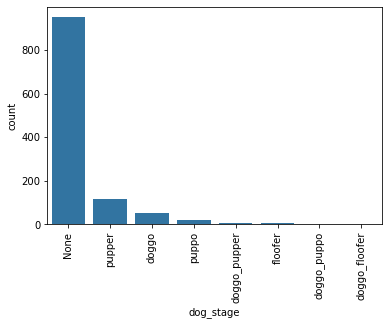

In [82]:
base_color = sns.color_palette()[0]
sns.countplot(data=df_master_clean,x='dog_stage',color = base_color,
              order=stage_counts.index)
plt.xticks(rotation='vertical');

It is observed that majority of the tweets in the wrangled and cleaned dataset did not mention the dog stage. Among the tweets that did mention, pupper was the most commonly used.

**2. Change in retweet_count and favorite_count over time**

In [83]:
#reindexing by timestamp
df_master_clean.index=df_master_clean['timestamp']

In [84]:
#finding average retweet_count by month
avg_retweet=df_master_clean.groupby(pd.Grouper(freq='M')).retweet_count.mean()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


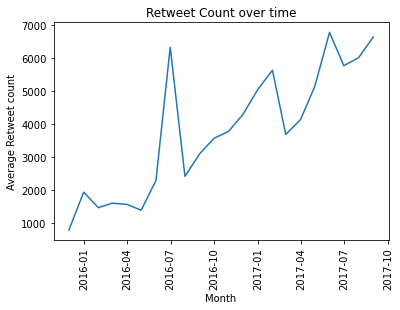

In [85]:
#plotting average retweet_count by month
plt.plot(avg_retweet)
plt.title('Retweet Count over time')
plt.xlabel('Month')
plt.ylabel('Average Retweet count')
plt.xticks(rotation='vertical');

In [86]:
#finding average favorite_count by month
avg_favorite=df_master_clean.groupby(pd.Grouper(freq='M')).favorite_count.mean()

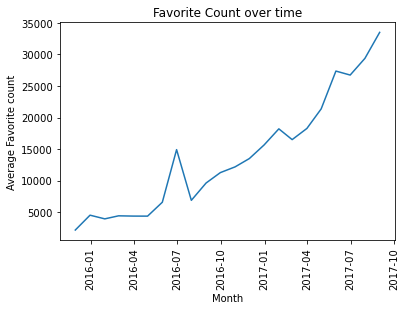

In [87]:
#plotting average favorite_count by month
plt.plot(avg_favorite)
plt.title('Favorite Count over time')
plt.xlabel('Month')
plt.ylabel('Average Favorite count')
plt.xticks(rotation='vertical');

It is observed that both retweet count and favorite count peaked in July, 2016. After July, 2016, favorite decreased only for few months and then showed an increasing trend. Retweet count too showed an increasing trend but it was not smooth and had peaks and dips. Moreover while the favorite count surpassed the peak in July’16 greatly, the retweet count has not increased much greater than July’16.

**Most common top image prediction**

In [88]:
#finding the images that been predicted more than 10 times
image_counts=df_master_clean['p1'].value_counts().reset_index()
image_counts=image_counts.query('p1>=10')
image_counts

,index,p1
0,golden_retriever,111
1,pembroke,74
2,labrador_retriever,63
3,chihuahua,46
4,chow,34
5,samoyed,34
6,pomeranian,28
7,toy_poodle,27
8,pug,22
9,cocker_spaniel,19


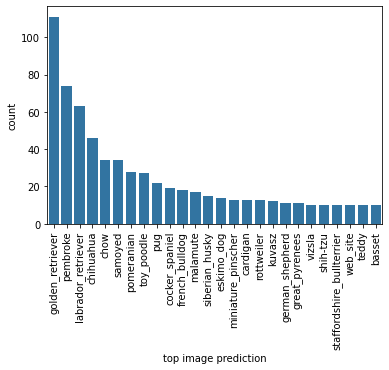

In [89]:
base_color = sns.color_palette()[0]
sns.countplot(data=df_master_clean,x='p1',color = base_color,
              order=image_counts['index'])
plt.xticks(rotation='vertical')
plt.xlabel('top image prediction');

A neural network classified the images of the dogs into breed. The top prediction was analysed. Golden retrievers is the most commonly predicted breed for the dog. This is followed by Pembroke and Labrador retriever. 